In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Michi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Michi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Michi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
data = pd.read_csv("data/Recommendations.csv")
data

,Recommendation
0,Accept a lower level of service
1,Accept risks of untested scenarios and change ...
2,"Acknowledge mistakes, compensate"
3,"Acknowledge mistakes, compensate and give insi..."
4,Actively communicate status and expected resol...
...,...
256,Use the CRT feedback loop to verify effectiven...
257,Vendor must perform more tests
258,VNR / Dual SIM
259,VNR / Dual SIM


In [5]:
def text_process(text):
    # Takes in a string of text, then performs the following:
    # 1. Remove all punctuation
    # 2. Remove all stopwords
    # 3. Return the cleaned text as a list of words
    # 4. Remove words
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in nopunc]

In [6]:
def tokenize(data):
    tokenized = []
    for rec in data:
        tokenized.append(text_process(rec))
    return tokenized

In [7]:
def tfidf_input(data):
    docs = []
    for sentence in data:
        docs.append(" ".join(text_process(sentence)))
        # print(sentence)
        # doc = []
        # for word in sentence:
        #     doc.append(word)
    # docs.append(sentence)
    return docs


In [8]:
tfidf_input(data["Recommendation"])

['accept lower level service',
 'accept risk untested scenario change service level accordingly',
 'acknowledge mistake compensate',
 'acknowledge mistake compensate give insight use improvement',
 'actively communicate status expected resolution time available',
 'align required available crisis comms channel heat moment',
 'apply change management roadmap cm process program management',
 'ask smart phone vendor different retry scheme',
 'assign train deputy',
 'attach value improvement process',
 'be front runner well',
 'be part research report',
 'block number range release stepwise',
 'bronze v gold quality service level',
 'build crisis organisation',
 'business continuity plan',
 'buy tool',
 'central contact list',
 'central contact list',
 'central contact list',
 'chase resource write execute ivr recording',
 'check service connectivity case signalling storm give action perspective',
 'clear guideline crisis communication',
 'clear guideline crisis communication',
 'clear gui

In [11]:
tfidf = TfidfVectorizer()
matrix = tfidf.fit_transform(tfidf_input(tokenize(data["Recommendation"])))

In [13]:
output = pd.DataFrame(matrix.toarray(),columns=tfidf.get_feature_names_out(),index=data["Recommendation"])
output


,acceptlowerlevelservice,acceptriskuntestedscenariochangeservicelevelaccordingly,acknowledgemistakecompensate,acknowledgemistakecompensategiveinsightuseimprovement,activelycommunicatestatusexpectedresolutiontimeavailable,alignrequiredavailablecrisiscommschannelheatmoment,applychangemanagementroadmapcmprocessprogrammanagement,asksmartphonevendordifferentretryscheme,assigntraindeputy,attachvalueimprovementprocess,...,uselatentneedpartmarketingcrisiscommunication,usemteam,useproventechnology,userelyhighlevelrootcausehumanfailureprocesfailuretechnologyfailuresteadlowerlevelrootcause,userelypreparedprocesstatementsteadcontentstatement,usesocialmediumtoollikeallestoringennlearlyindicatorinformcustomerpressproactively,usespecificcommunicationplancriticalcustomer,usestandarddevelopmentspecification,vendormustperformtest,vnrdualsim
Recommendation,,,,,,,,,,,,,,,,,,,,,
Accept a lower level of service,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Accept risks of untested scenarios and change service levels accordingly,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Acknowledge mistakes, compensate",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Acknowledge mistakes, compensate and give insight how to use this for improvements",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Actively communicate status and expected resolution time if available,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Use the CRT feedback loop to verify effectiveness of the crisis communication,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vendor must perform more tests,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
VNR / Dual SIM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Clustering

### KMEANS

In [205]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    
    sse = []
    silhouette = []
    for k in iters:
        km = KMeans(n_clusters=k)
        sse.append(km.fit(data).inertia_)
        silhouette.append(silhouette_score(data, km.labels_))
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    plt.tight_layout()

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, silhouette, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Score')
    ax.set_title('Silhoute Score by Cluster')
    plt.tight_layout()

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


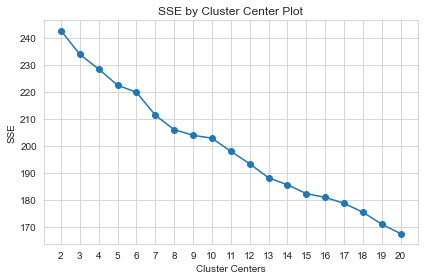

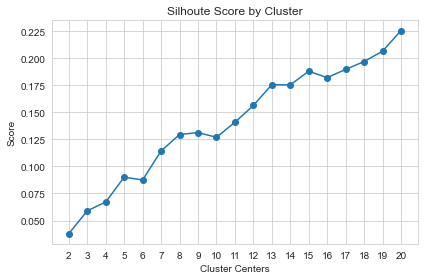

In [206]:
find_optimal_clusters(matrix,max_k=20)

In [217]:
bandwidth = estimate_bandwidth(matrix.to2darray, 
                               quantile=0.3, 
                               n_jobs=-1)

ms = MeanShift(bandwidth=bandwidth).fit(matrix.toarray())
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print(f"Number of estimated clusters : {n_clusters_}")

AttributeError: to2darray not found

In [222]:
kmeans = KMeans(n_clusters=200)
kmeans.fit(matrix)
silhouette_score(matrix, kmeans.labels_, metric='euclidean')

C:\Users\Michi\AppData\Local\Temp\ipykernel_25356\2032512257.py:2: ConvergenceWarning: Number of distinct clusters (179) found smaller than n_clusters (200). Possibly due to duplicate points in X.
  kmeans.fit(matrix)


0.4521072796934866

In [184]:
data["cluster"] = kmeans.labels_

In [185]:
data.head(30)

,Recommendation,cluster
0,Accept a lower level of service,1
1,Accept risks of untested scenarios and change ...,1
2,"Acknowledge mistakes, compensate",1
3,"Acknowledge mistakes, compensate and give insi...",1
4,Actively communicate status and expected resol...,4
5,Align with required and available crisis comms...,1
6,"Apply Change Management (Roadmap, CM process, ...",1
7,Ask smart phone vendors for different retry sc...,1
8,Assign and train deputies,1
9,Attach value to improvement processes,1


### Hierarchical Clustering

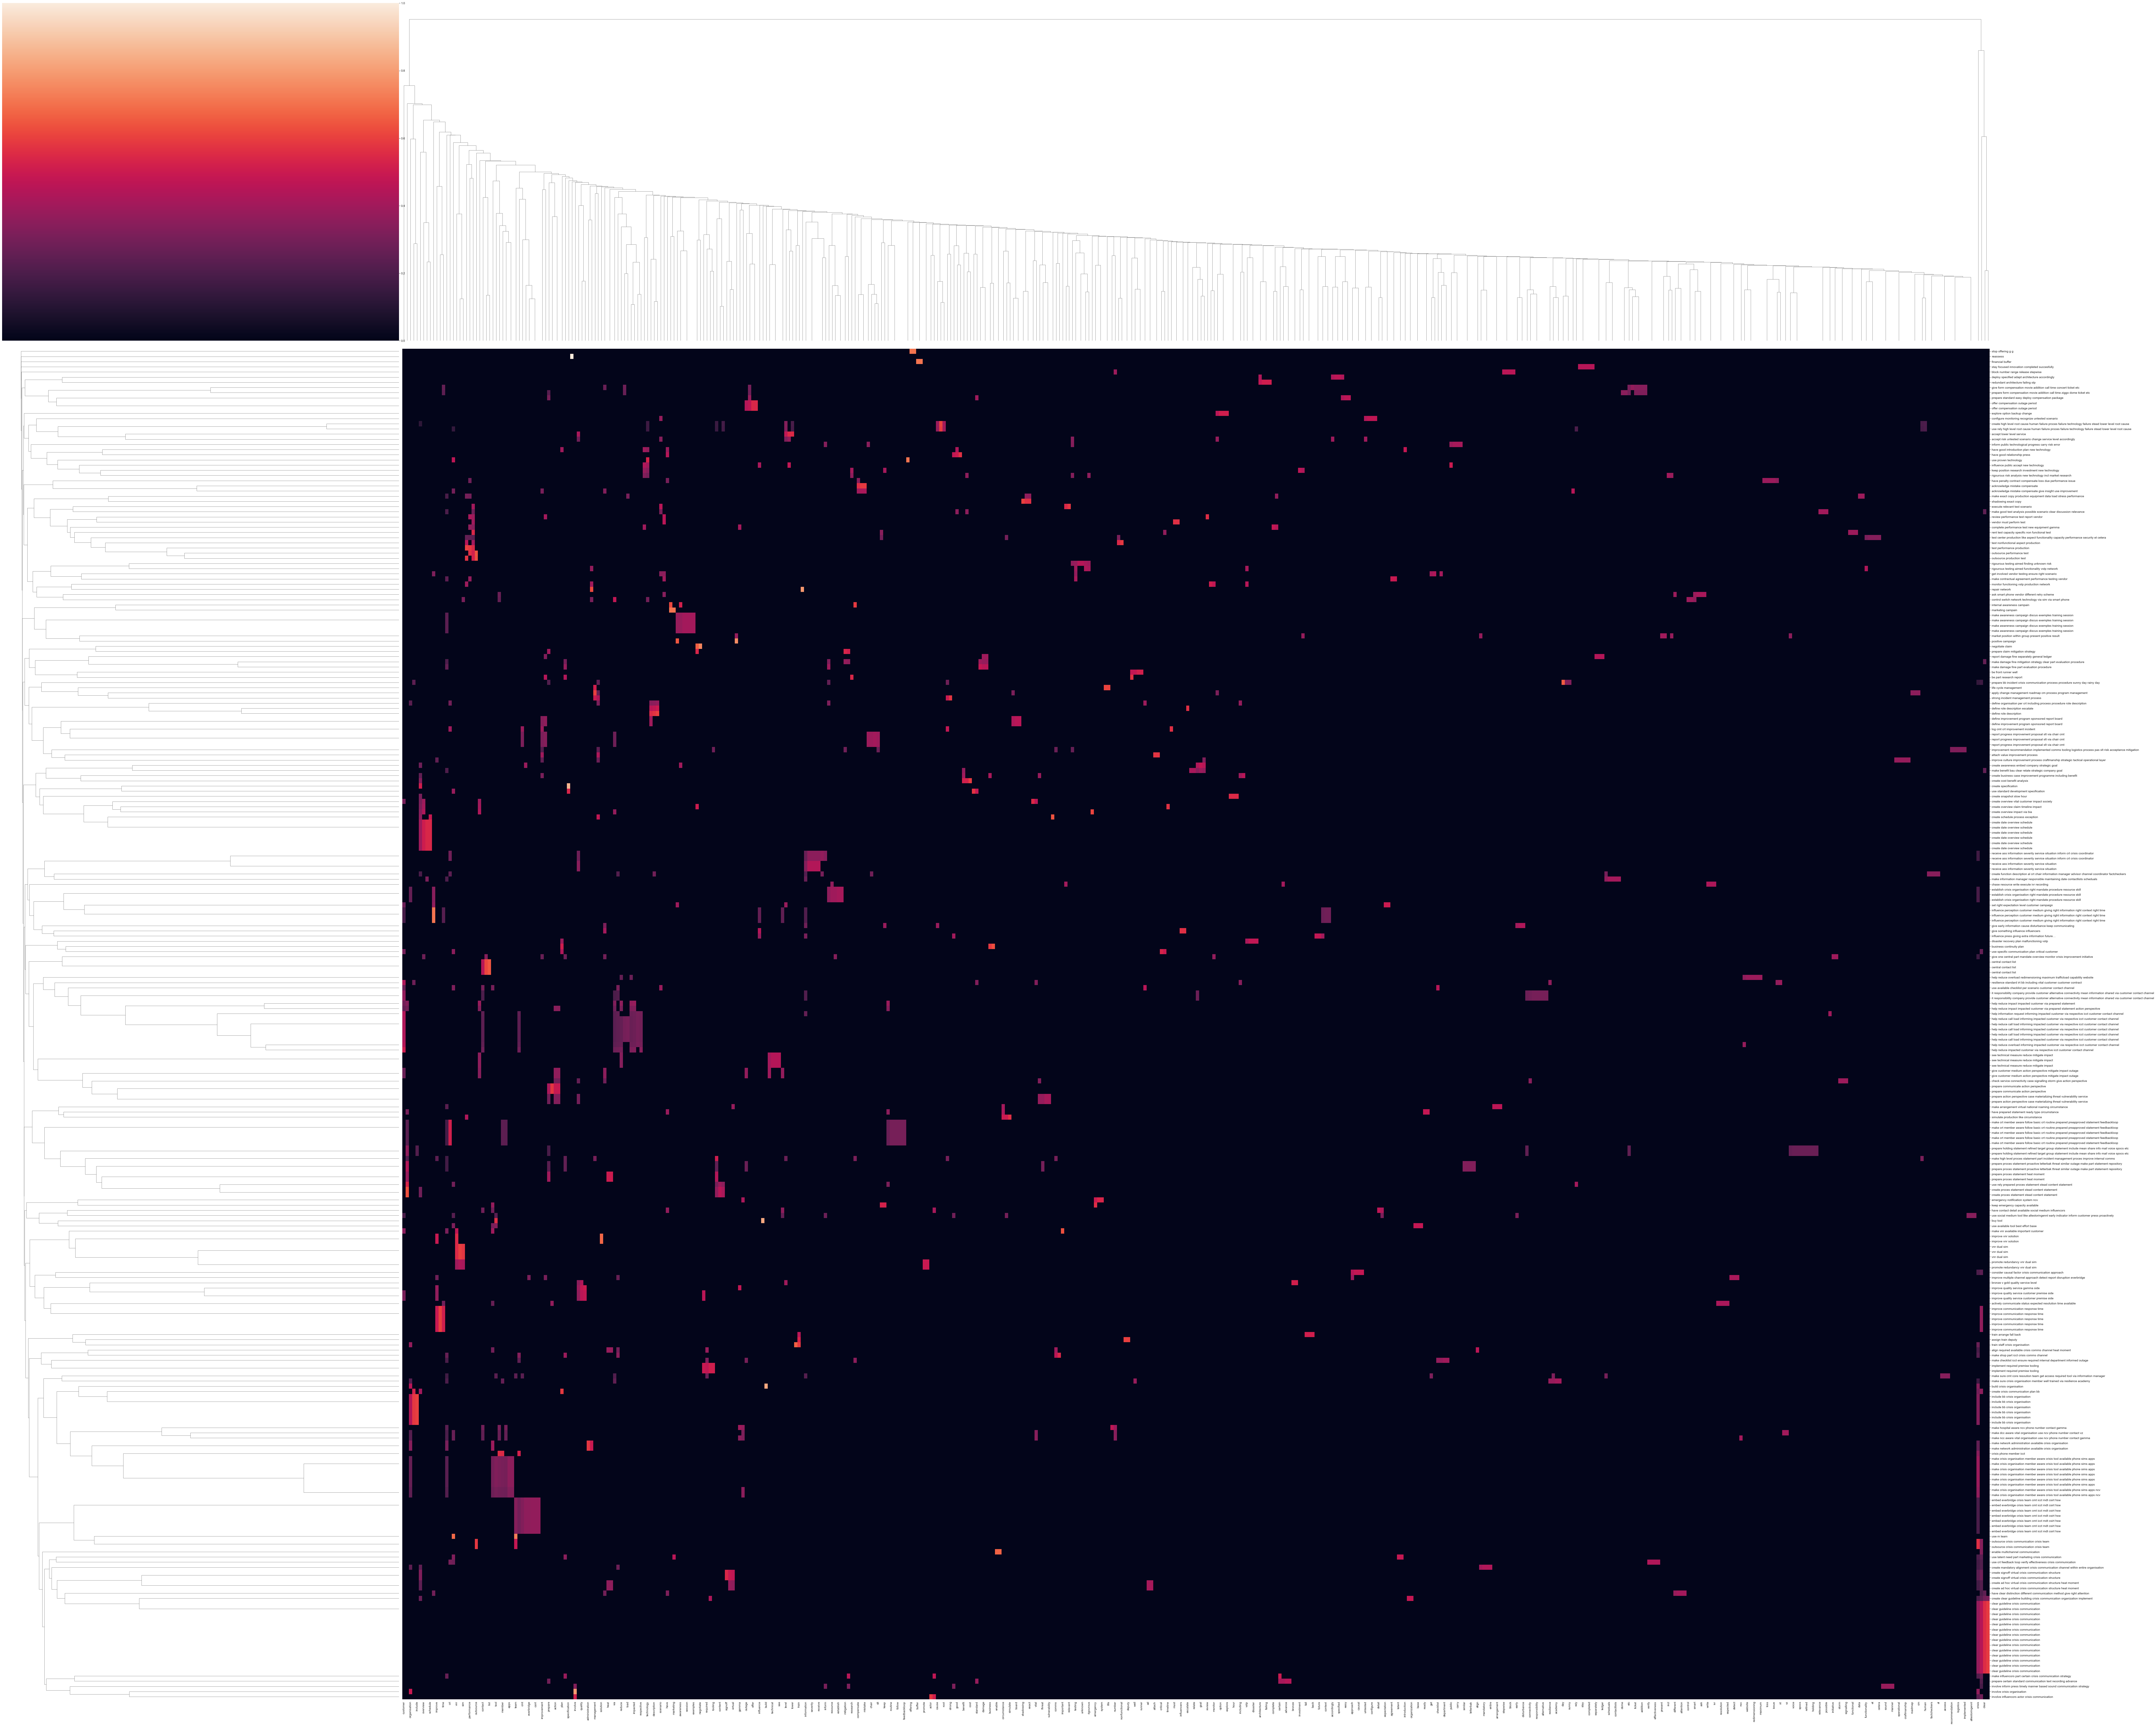

In [166]:
sns.set_style("whitegrid")
clustermap = sns.clustermap(output,figsize=(100,80))
plt.tight_layout()
clustermap.savefig("out.png") 